# INF1032 - Trabalho 1.2 - Classificação de vinhos
### Alunos: Leonardo Wajnsztok e Samuel Bastos

O objetivo deste trabalho é comparar diversos métodos de classificação para a base de dados de qualidade de vinhos disponível em https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv.

Vocês devem encontrar um bom modelo preditivo, variando:
* o número e conjunto de features (atributos) utilizados
* o método utilizado
* a configuração do algoritmo correspondente (e.g.: número k para nearest neighbors, profundidade para árvore de decisão)

Vocês devem listar algumas métricas de qualidade, tais como: precision, recall, accuracy e f1_score, e utilizar accuracy como base para a avaliação final, considerando a accuracy média de 10 iterações para cada configuração.

Para assegurar que eu obterei os mesmos resultados de vocês, vocês devem estabelecer a semente para a geração dos números aleatórios (utilizados para separar os conjuntos de treinamento e teste, por exemplo), utilizando os seguintes comandos no início do seu código (podem utilizar uma outra semente):
```
import random
random.seed(1001001)
```

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random

seed = 1032
random.seed(seed)

# Read dataset

In [21]:
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
initial_df = pd.read_csv(dataset_url, sep=";")

# Dataset analysis

In [22]:
initial_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [23]:
initial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [24]:
initial_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [25]:
label_column = 'quality'
feature_columns = set(initial_df.columns)
feature_columns.remove(label_column)
feature_columns = list(feature_columns)

print (label_column, feature_columns)

quality ['citric acid', 'total sulfur dioxide', 'fixed acidity', 'free sulfur dioxide', 'residual sugar', 'chlorides', 'volatile acidity', 'sulphates', 'pH', 'alcohol', 'density']


In [26]:
initial_df.groupby(label_column).size().reset_index(name="count")

,quality,count
0,3,10
1,4,53
2,5,681
3,6,638
4,7,199
5,8,18


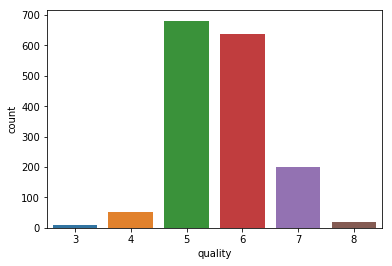

In [27]:
sns.countplot(x='quality', data=initial_df)

- 1599 rows
- 6 labels
- Dataset is not balanced
- No missing values
- All features are numeric and they are in different scales

# Train, Test split

In [28]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

test_size = 0.2
n_folds = 3

X_train_raw, X_test_raw, y_train, y_test = train_test_split(initial_df[feature_columns], initial_df[label_column], test_size=test_size, random_state=seed)

# Validation pipeline

In [29]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def apply_validation_pipeline(name, model, params, X_train, y_train):
    pipe = Pipeline([('m', model)])
    grid = GridSearchCV(pipe, params, n_jobs=1, cv=n_folds)
    grid = grid.fit(X_train, y_train)

    print ("Model: "+ name)
    print ("Best cross-validation score: " + str(grid.best_score_))
    print ("Best parameters: " + str(grid.best_params_))
    return grid, grid.best_score_

def test_models(name, dataset_name, X_test, y_test, trained_model):
    predictions = trained_model.predict(X_test)
    print ("Model: "+ name)
    print ("Dataset: "+ dataset_name)
    test_accuracy = accuracy_score(y_test, predictions)
    print ("Accuracy score :" + str(test_accuracy))
    print (confusion_matrix(y_test, predictions))
    print (classification_report(y_test, predictions))
    return test_accuracy

# Models and parameters grids

In [30]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier

models_params = [
    ('LinearSVC', LinearSVC(random_state=seed), {'m__C': [0.1, 1, 10], 'm__dual': [True, False]}),
    ('KNN', KNeighborsClassifier(), {'m__n_neighbors': range(3,30)}),
    ('Decision Tree', DecisionTreeClassifier(random_state=seed), {'m__max_depth': range(3, 20)}),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=seed), {'m__n_estimators': [100, 200, 300]}),
    ('Random Forest', RandomForestClassifier(random_state=seed), { "m__n_estimators": [10, 30, 50, 70]}),
    ('Logistic Regression', LogisticRegression(), {}),
    ('SGD', SGDClassifier(random_state=seed), { 'm__alpha': (1e-2, 1e-3),
                                                'm__max_iter': (1000, 2000),
                                                'm__penalty': ('l2', 'elasticnet'),
                                               }),
    ('Gaussian Naive Bayes', GaussianNB(), {}),
    ('Multinomial Naive Bayes', MultinomialNB(), {}),
    ('Multilayer Perceptron', MLPClassifier(random_state=seed), {'m__max_iter': [500, 1000]})
]

# Generate preprocessed datasets

In [31]:
from sklearn.preprocessing import StandardScaler, normalize

# Don't cheat - fit only on training data
# apply same transformation to test data

scaler = StandardScaler()
scaler.fit(X_train_raw)  
X_train_scaled = scaler.transform(X_train_raw) + 4 # prevent negative values
X_test_scaled = scaler.transform(X_test_raw) + 4 # prevent negative values

X_train_norm = normalize(X_train_raw, axis=0)
X_test_norm = normalize(X_test_raw, axis=0)

datasets = [
    ('Default dataset', X_train_raw, y_train, X_test_raw, y_test),
    ('Standard Scaled dataset', X_train_scaled, y_train, X_test_scaled, y_test),
    ('Normalized dataset', X_train_norm, y_train, X_test_norm, y_test),
]

In [32]:
pd.DataFrame(X_train_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,10
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
std,1.000391,1.000391,1.000391,1.000391,1.000391,1.000391,1.000391,1.000391,1.000391,1.000391,1.000391
min,2.595306,2.755990,1.951428,2.588752,2.874595,2.417463,1.689150,2.317579,0.343322,2.101866,0.513867
25%,3.106533,3.252711,3.297987,3.154534,3.559531,3.628028,3.243490,3.356713,3.290727,3.127706,3.395855
50%,3.924495,3.749431,3.746840,3.814613,3.765012,3.815874,3.991876,3.760821,3.995541,3.780514,3.979549
75%,4.793580,4.463466,4.532333,4.568989,4.038986,4.055900,4.625125,4.395848,4.572208,4.619838,4.578878
max,7.707572,11.200236,8.235371,9.283841,12.874660,14.898809,8.654896,11.727520,8.480723,8.163650,7.612001


In [33]:
pd.DataFrame(X_train_norm).describe()

,0,1,2,3,4,5,6,7,8,9,10
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,0.022779,0.022916,0.027346,0.023292,0.024250,0.024546,0.026528,0.027050,0.027931,0.027815,0.027962
std,0.016223,0.016028,0.005838,0.015477,0.013927,0.013397,0.008841,0.007087,0.001317,0.002859,0.000054
min,0.000000,0.002984,0.015390,0.001459,0.008582,0.003354,0.006105,0.015131,0.023116,0.022390,0.027774
25%,0.008290,0.010943,0.023249,0.010212,0.018118,0.019565,0.019842,0.022493,0.026997,0.025322,0.027929
50%,0.021555,0.018902,0.025868,0.020424,0.020978,0.022081,0.026457,0.025355,0.027925,0.027188,0.027961
75%,0.035648,0.030342,0.030453,0.032095,0.024792,0.025295,0.032053,0.029854,0.028684,0.029587,0.027993
max,0.082903,0.138280,0.052064,0.105037,0.147801,0.170497,0.067668,0.081791,0.033830,0.039716,0.028156


# Validate

In [34]:
models_info = []

for dataset_name, X_train, y_train, X_test, y_test in datasets:
    print (dataset_name)
    for name, model, params in models_params:
        trained_model, val_accuracy = apply_validation_pipeline(name, model, params, X_train, y_train)
        models_info.append({
            'name': name, 'dataset_name': dataset_name,
            'X_test': X_test, 'y_test': y_test,
            'trained_model': trained_model, 'validation_accuracy': val_accuracy
        })
    print ()

Default dataset
Model: LinearSVC
Best cross-validation score: 0.5770132916340891
Best parameters: {'m__C': 0.1, 'm__dual': False}
Model: KNN
Best cross-validation score: 0.5316653635652854
Best parameters: {'m__n_neighbors': 21}
Model: Decision Tree
Best cross-validation score: 0.5863956215793589
Best parameters: {'m__max_depth': 16}
Model: Gradient Boosting
Best cross-validation score: 0.6293979671618452
Best parameters: {'m__n_estimators': 200}
Model: Random Forest
Best cross-validation score: 0.653635652853792
Best parameters: {'m__n_estimators': 70}
Model: Logistic Regression
Best cross-validation score: 0.5832681782642689
Best parameters: {}
Model: SGD
Best cross-validation score: 0.544175136825645
Best parameters: {'m__penalty': 'l2', 'm__alpha': 0.01, 'm__max_iter': 1000}
Model: Gaussian Naive Bayes
Best cross-validation score: 0.5261923377638781
Best parameters: {}
Model: Multinomial Naive Bayes
Best cross-validation score: 0.4292415949960907
Best parameters: {}
Model: Multilay

# Test

In [16]:
for mi in models_info:
    mi['test_accuracy'] = test_models(mi['name'], mi['dataset_name'], mi['X_test'], mi['y_test'], mi['trained_model'])

Model: LinearSVC
Dataset: Default dataset
Accuracy score :0.590625
[[  0   0   2   0   0   0]
 [  0   0  12   3   0   0]
 [  0   0 122  22   0   0]
 [  0   0  52  67   0   0]
 [  0   0   4  31   0   0]
 [  0   0   0   5   0   0]]
             precision    recall  f1-score   support

          3       0.00      0.00      0.00         2
          4       0.00      0.00      0.00        15
          5       0.64      0.85      0.73       144
          6       0.52      0.56      0.54       119
          7       0.00      0.00      0.00        35
          8       0.00      0.00      0.00         5

avg / total       0.48      0.59      0.53       320

Model: KNN
Dataset: Default dataset
Accuracy score :0.559375
[[  0   0   1   0   1   0]
 [  0   0   6   8   1   0]
 [  0   0 107  37   0   0]
 [  0   0  50  67   2   0]
 [  0   0   9  21   5   0]
 [  0   0   3   2   0   0]]
             precision    recall  f1-score   support

          3       0.00      0.00      0.00         2
          4 

/Users/LeoWajnsztok/Documents/PUC/INF1032/env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Model: Gradient Boosting
Dataset: Normalized dataset
Accuracy score :0.096875
[[ 0  0  0  0  1  1]
 [ 0  0  0  0 12  3]
 [ 1  4  2  6 99 32]
 [ 1  0  2  4 86 26]
 [ 0  0  1  3 24  7]
 [ 0  0  1  0  3  1]]
             precision    recall  f1-score   support

          3       0.00      0.00      0.00         2
          4       0.00      0.00      0.00        15
          5       0.33      0.01      0.03       144
          6       0.31      0.03      0.06       119
          7       0.11      0.69      0.18        35
          8       0.01      0.20      0.03         5

avg / total       0.28      0.10      0.06       320

Model: Random Forest
Dataset: Normalized dataset
Accuracy score :0.4375
[[ 0  0  0  2  0  0]
 [ 0  0  2 13  0  0]
 [ 0  0 43 95  6  0]
 [ 0  0 19 96  4  0]
 [ 0  0  1 33  1  0]
 [ 0  0  1  3  1  0]]
             precision    recall  f1-score   support

          3       0.00      0.00      0.00         2
          4       0.00      0.00      0.00        15
         

In [17]:
models_info_df = pd.DataFrame(models_info).sort_values('test_accuracy', ascending=False)
models_info_df.head()

,X_test,dataset_name,name,test_accuracy,trained_model,validation_accuracy,y_test
14,"[[3.004350508624667, 3.5785202800521105, 2.965...",Standard Scaled dataset,Random Forest,0.70000,"GridSearchCV(cv=3, error_score='raise',\n ...",0.652072,1169 6 70 6 902 7 1508 6 1156 ...
4,total sulfur dioxide fixed acidity fre...,Default dataset,Random Forest,0.69375,"GridSearchCV(cv=3, error_score='raise',\n ...",0.652072,1169 6 70 6 902 7 1508 6 1156 ...
3,total sulfur dioxide fixed acidity fre...,Default dataset,Gradient Boosting,0.68125,"GridSearchCV(cv=3, error_score='raise',\n ...",0.634871,1169 6 70 6 902 7 1508 6 1156 ...
13,"[[3.004350508624667, 3.5785202800521105, 2.965...",Standard Scaled dataset,Gradient Boosting,0.68125,"GridSearchCV(cv=3, error_score='raise',\n ...",0.635653,1169 6 70 6 902 7 1508 6 1156 ...
11,"[[3.004350508624667, 3.5785202800521105, 2.965...",Standard Scaled dataset,KNN,0.63125,"GridSearchCV(cv=3, error_score='raise',\n ...",0.582486,1169 6 70 6 902 7 1508 6 1156 ...


In [18]:
def plot_bar_result(x, y, title=''):
    fig, ax = plt.subplots()
    ax.set(xlim=(0, 1)) 
    ax.set(xticks=np.arange(0,1.05,0.05))
    fig.set_size_inches(12, 9)
    ax = sns.barplot(x=x, y=y, ax=ax)
    ax.set_title(title)
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 0.05  ,
                p.get_y()+p.get_height()/2. + 0.2,
                '{:1.4f}'.format(width),
                ha="center")

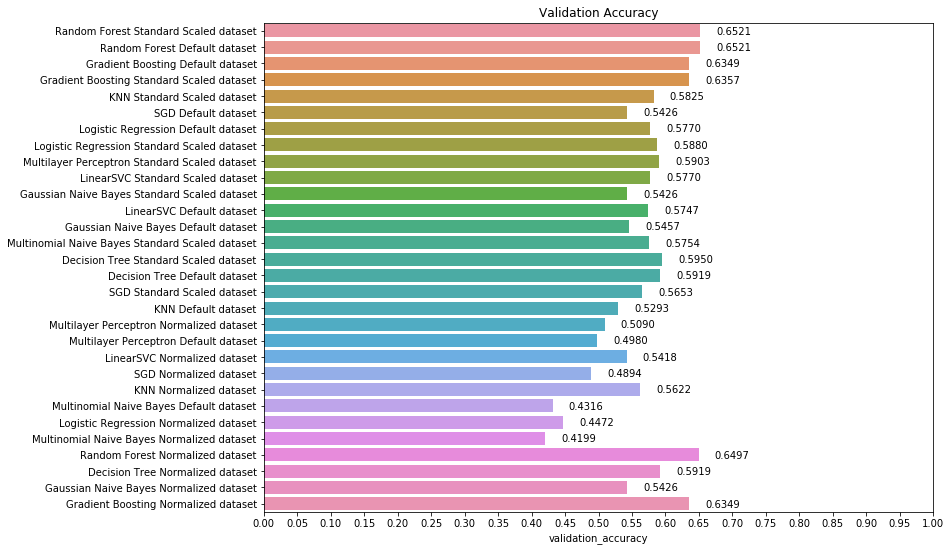

In [19]:
plot_bar_result(models_info_df['validation_accuracy'], models_info_df['name'] + ' ' +  models_info_df['dataset_name'], title='Validation Accuracy')

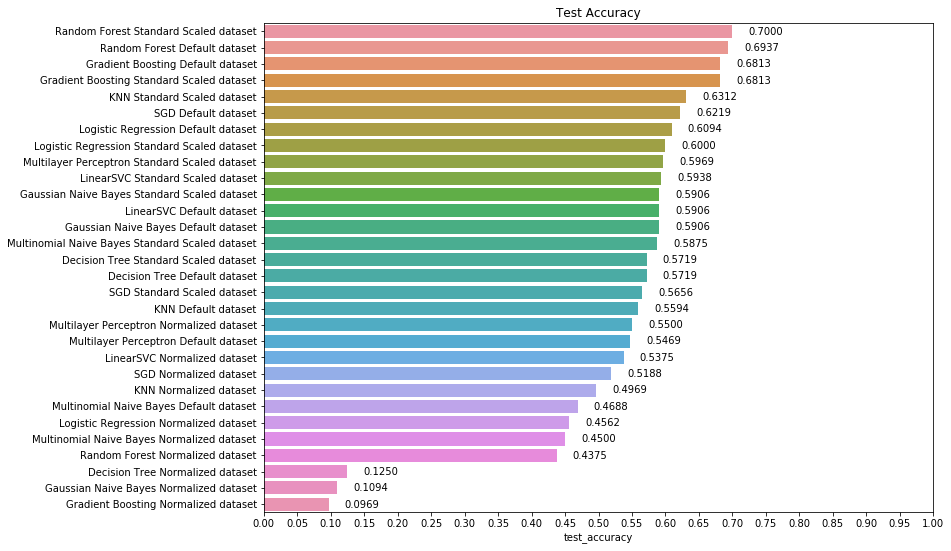

In [20]:
plot_bar_result(x=models_info_df['test_accuracy'], y=models_info_df['name'] + ' ' +  models_info_df['dataset_name'], title='Test Accuracy')

# Feature importances

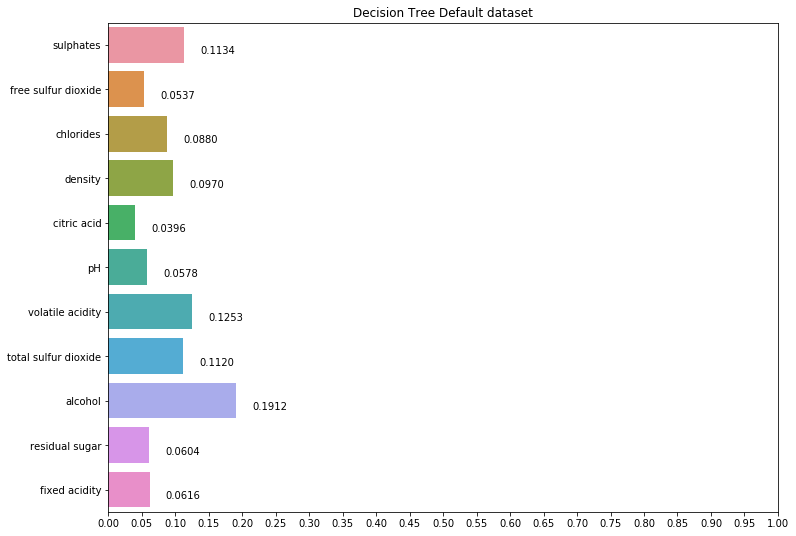

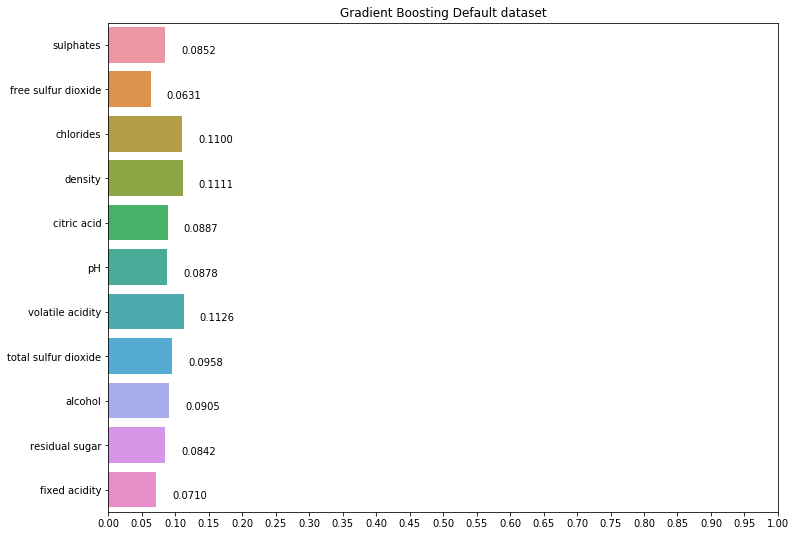

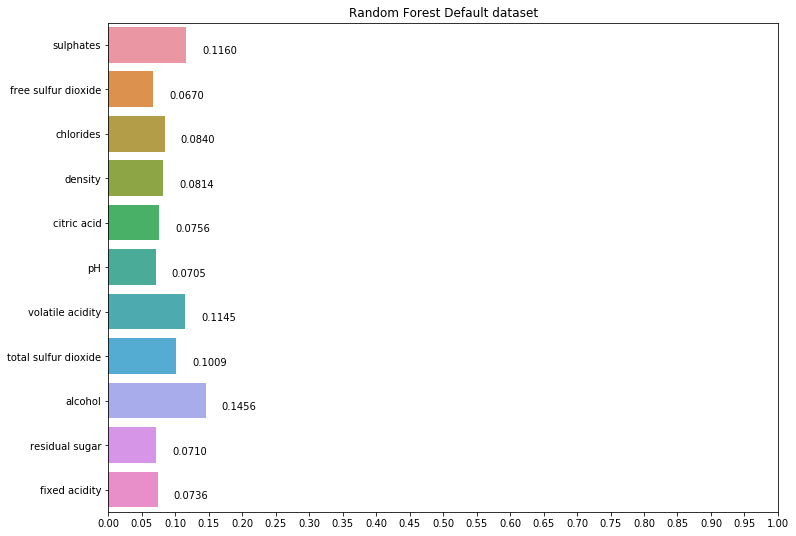

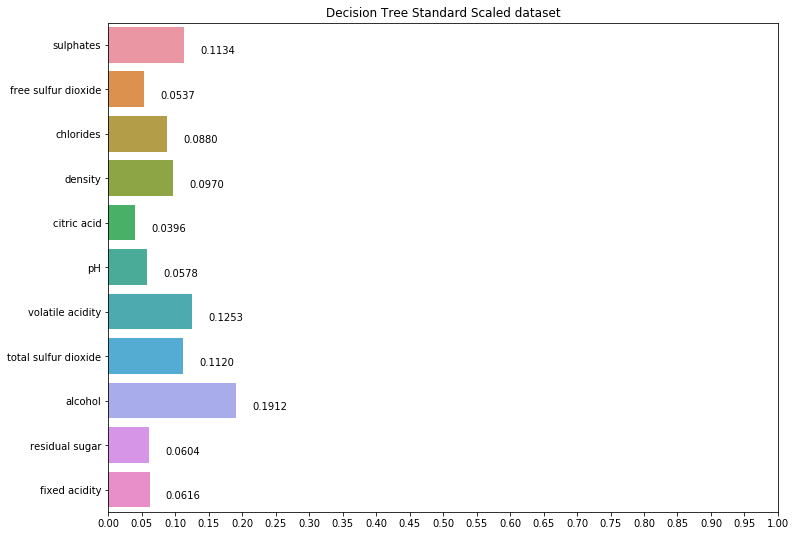

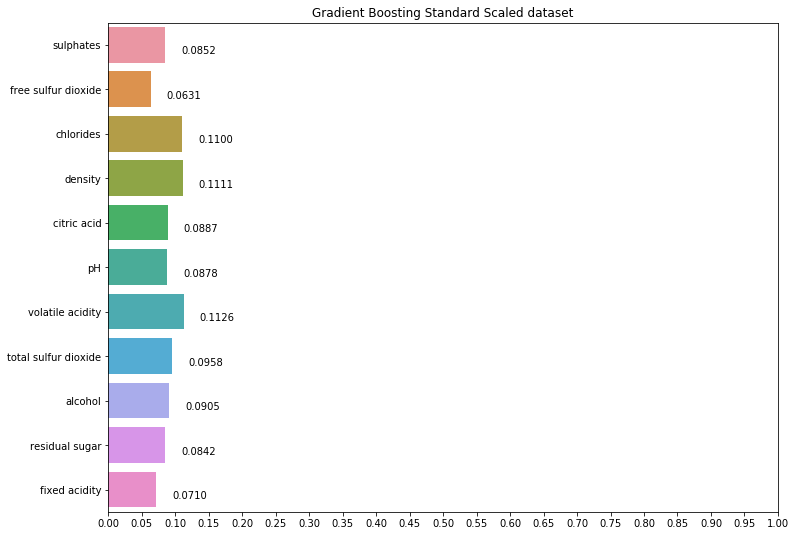

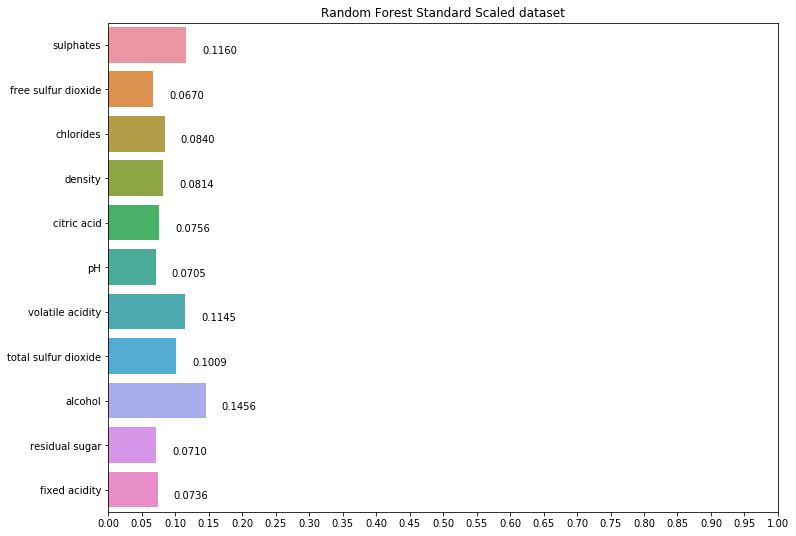

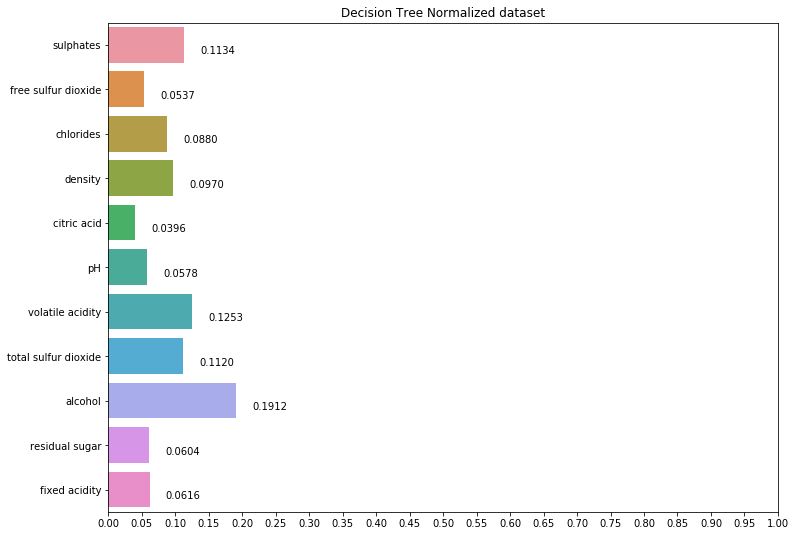

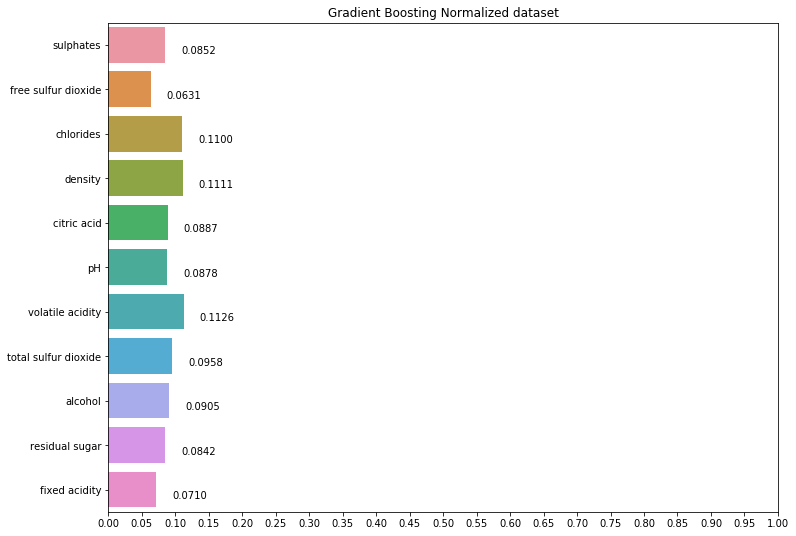

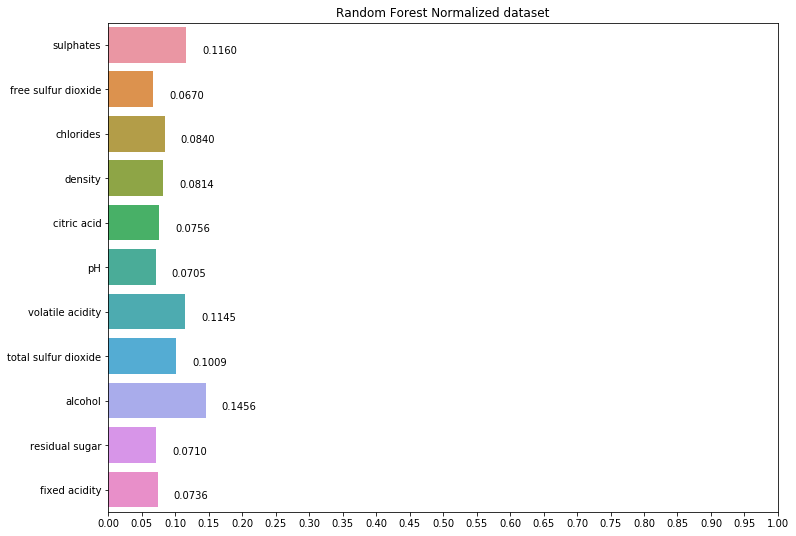

In [141]:
for m in models_info:
    try:
        plot_bar_result(
            m['trained_model'].best_estimator_.steps[0][1].feature_importances_,
            feature_columns,
            title=m['name'] + ' ' + m['dataset_name'])
    except AttributeError:
        pass

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
x_pca = pca.fit_transform(x)